cs231n/classifiers/softmax.py 파일을 여기로 합쳤습니다.

# Softmax exercise

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


## CIFAR-10 Data Loading and Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10  

# 데이터 전처리 방식은 svm과 같다.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# subsample the data
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask].astype('float64')
y_val = y_train[mask]
mask = range(num_training)
X_train = X_train[mask].astype('float64')
y_train = y_train[mask]
mask = range(num_test)
X_test = X_test[mask].astype('float64')
y_test = y_test[mask]
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask].astype('float64')
y_dev = y_train[mask]

# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# Normalize the data: subtract the mean image
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# add bias dimension and transform into columns
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

Using TensorFlow backend.


(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Softmax Classifier (naive)

In [2]:
def softmax_loss_naive(W, X, y, reg):
    
    loss = 0.0
    dW = np.zeros_like(W)
    num_train = X.shape[0]
    
    for i in range(num_train):
        scores = np.dot(X[i], W)
        scores -= np.max(scores) # normalization trick for numeric stability
        scores_exp = np.exp(scores)
        scores_expsum = np.sum(scores_exp)
        loss += -scores[y[i]] + np.log(scores_expsum)
        dW += np.dot(X[i].reshape(-1,1), scores_exp.reshape(1,-1)) / scores_expsum
        dW[:, y[i]] -= X[i]
        
    loss /= num_train
    loss += np.sum(W*W)
    dW /= num_train
    dW += 2 * reg * W
    
    return loss, dW

#### loss check

In [3]:
W = np.random.randn(3073, 10) * 0.00001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1) = 랜덤 추측의 기대 손실값.
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.302580
sanity check: 2.302585


#### gradients check

In [4]:
from cs231n.gradient_check import grad_check_sparse

# 규제 없이 그레디언트 체크
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.337467 analytic: 2.337481, relative error: 3.000348e-06
numerical: 1.249165 analytic: 1.249154, relative error: 4.646828e-06
numerical: 1.234856 analytic: 1.234842, relative error: 5.802200e-06
numerical: -0.091304 analytic: -0.091323, relative error: 1.037262e-04
numerical: -3.864538 analytic: -3.864566, relative error: 3.633269e-06
numerical: -1.272824 analytic: -1.272812, relative error: 4.754312e-06
numerical: 0.587987 analytic: 0.588003, relative error: 1.403991e-05
numerical: 1.521838 analytic: 1.521830, relative error: 2.822122e-06
numerical: -0.549806 analytic: -0.549785, relative error: 1.858919e-05
numerical: 0.452490 analytic: 0.452461, relative error: 3.259570e-05


In [5]:
# 규제를 가한 후 그레디언트 체크
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.979212 analytic: 1.979192, relative error: 5.069877e-06
numerical: 2.725043 analytic: 2.725267, relative error: 4.111751e-05
numerical: 2.020536 analytic: 2.020139, relative error: 9.825965e-05
numerical: -1.139183 analytic: -1.139311, relative error: 5.626429e-05
numerical: -2.773556 analytic: -2.774214, relative error: 1.186936e-04
numerical: -0.448343 analytic: -0.448229, relative error: 1.272309e-04
numerical: 0.150926 analytic: 0.150864, relative error: 2.047912e-04
numerical: -0.448343 analytic: -0.448229, relative error: 1.272309e-04
numerical: 0.626992 analytic: 0.628398, relative error: 1.119607e-03
numerical: -1.745013 analytic: -1.743895, relative error: 3.203573e-04


## Softmax Classifier (vetorized)

In [6]:
def softmax_loss_vectorized(W, X, y, reg):

    num_train = X.shape[0]
    
    scores = np.dot(X, W)
    scores -= np.max(scores, axis=1, keepdims=True)
    scores_exp = np.exp(scores)
    scores_expsum = np.sum(scores_exp, axis=1, keepdims=True)
    loss = np.sum(-scores[range(num_train), y] + np.log(scores_expsum).reshape(-1)) 
    
    loss /= num_train
    loss += np.sum(W*W)
    
    s = scores_exp/scores_expsum
    s[range(num_train), y] -= 1
    dW = np.dot(X.T, s) 
    dW /= num_train
    dW += 2 * reg * W
    
    return loss, dW

In [7]:
import time

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.302580e+00 computed in 0.046874s
vectorized loss: 2.302580e+00 computed in 0.002995s
Loss difference: 0.000000
Gradient difference: 0.000000


## 하이퍼 파라미터 튜닝

In [8]:
class Softmax(): # loss 함수를 제외하고 svm에서 한 것과 같다.
    def __init__(self):
        self.W = None
    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200, verbose=False):
        num_train, dim = X.shape
        num_classes = np.max(y) + 1
        if self.W is None: 
            self.W = 0.001 * np.random.randn(dim, num_classes)
        loss_history = []
        for it in range(num_iters):
            batch_index = np.random.choice(np.arange(num_train), batch_size)
            X_batch = X[batch_index]
            y_batch = y[batch_index]
            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)
            # perform parameter update
            self.W -= learning_rate * grad
            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))
        return loss_history
    def predict(self, X):
        y_pred = np.argmax(np.dot(X, self.W), axis=1)
        return y_pred
    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

In [9]:
results = {}
best_val = -1
best_softmax = None
learning_rates = (np.power(10, np.random.rand(30)) -1) / 9 * 5e-7 + 2e-7
regularization_strengths = np.power(10, np.random.rand(30)) * 5e3 + 2e4

for lr, rs in zip(learning_rates, regularization_strengths):
    softmax = Softmax()
    loss = softmax.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=200, verbose=False)
    train_acc = np.mean(softmax.predict(X_train) == y_train)
    val_acc = np.mean(softmax.predict(X_val) == y_val)
    results[(lr, rs)] = (train_acc, val_acc)

    if val_acc > best_val:
        best_val = val_acc
        best_softmax = softmax
        best_loss = loss
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.065166e-07 reg 2.548617e+04 train accuracy: 0.284796 val accuracy: 0.281000
lr 2.167715e-07 reg 3.194886e+04 train accuracy: 0.313265 val accuracy: 0.321000
lr 2.253500e-07 reg 2.525865e+04 train accuracy: 0.293122 val accuracy: 0.313000
lr 2.286283e-07 reg 3.397913e+04 train accuracy: 0.312837 val accuracy: 0.322000
lr 2.451493e-07 reg 2.919068e+04 train accuracy: 0.305367 val accuracy: 0.326000
lr 2.466422e-07 reg 3.148678e+04 train accuracy: 0.312673 val accuracy: 0.327000
lr 2.577042e-07 reg 2.563744e+04 train accuracy: 0.315959 val accuracy: 0.329000
lr 2.602462e-07 reg 3.326317e+04 train accuracy: 0.311020 val accuracy: 0.334000
lr 2.631477e-07 reg 2.876372e+04 train accuracy: 0.309714 val accuracy: 0.316000
lr 2.656796e-07 reg 6.775617e+04 train accuracy: 0.290327 val accuracy: 0.315000
lr 2.770210e-07 reg 3.983965e+04 train accuracy: 0.306265 val accuracy: 0.324000
lr 2.782509e-07 reg 3.017661e+04 train accuracy: 0.311408 val accuracy: 0.319000
lr 2.987732e-07 reg 2.520256

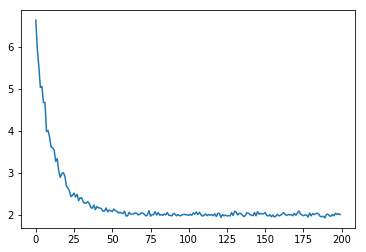

In [10]:
plt.plot(best_loss)
plt.show()

In [11]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.358000


### 가중치 시각화

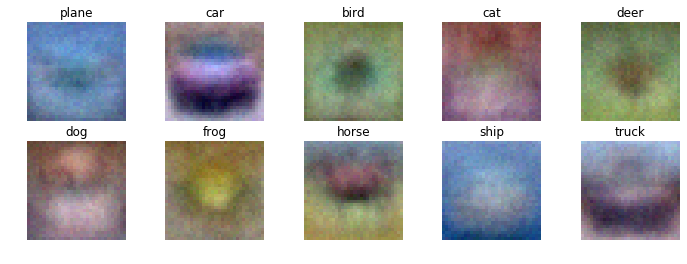

In [12]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(12,4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])